In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

In [2]:
data_dir = "C:/Users/user/OneDrive/Masaüstü/RGB_malwareimages"

# Define transformations for your images (adjust as needed)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Resize for EfficientNet-B3
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the ImageFolder dataset
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Define the validation set split ratio (e.g., 20% for validation)
val_split = 0.2

# Split the dataset into train and validation sets using random_split
train_size = int(len(dataset) * (1 - val_split))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

image_datasets = {
    'train': train_data,
    'val': val_data,
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = dataset.classes

# ... rest of your transfer learning code using train_loader and val_loader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

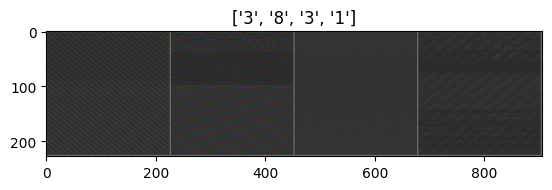

In [3]:
def imshow(inp, title=None):
    #Display image for Tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
writer = SummaryWriter("C:/Users/user/experiment_efficientnetb0_sgd_001_rgb")

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == "train":
                writer.add_scalar("Training Loss", epoch_loss, epoch)
                writer.add_scalar("Training Accuracy", epoch_acc, epoch)
            elif phase == 'val':
                writer.add_scalar("Validation Loss", epoch_loss, epoch)
                writer.add_scalar("Validation Accuracy", epoch_acc, epoch)
            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    writer.close()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1')
num_ftrs =  model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 9)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9) #0.01

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=120)

Epoch 0/119
----------
train Loss: 1.2580 Acc: 0.6027
val Loss: 0.8026 Acc: 0.7410

Epoch 1/119
----------
train Loss: 0.7955 Acc: 0.7310
val Loss: 0.7031 Acc: 0.7622

Epoch 2/119
----------
train Loss: 0.6952 Acc: 0.7690
val Loss: 0.5797 Acc: 0.8155

Epoch 3/119
----------
train Loss: 0.6101 Acc: 0.7971
val Loss: 0.5515 Acc: 0.8280

Epoch 4/119
----------
train Loss: 0.5518 Acc: 0.8144
val Loss: 0.6266 Acc: 0.7967

Epoch 5/119
----------
train Loss: 0.5181 Acc: 0.8248
val Loss: 0.4582 Acc: 0.8579

Epoch 6/119
----------
train Loss: 0.4643 Acc: 0.8455
val Loss: 0.5048 Acc: 0.8482

Epoch 7/119
----------
train Loss: 0.3784 Acc: 0.8750
val Loss: 0.3578 Acc: 0.8827

Epoch 8/119
----------
train Loss: 0.3313 Acc: 0.8858
val Loss: 0.3250 Acc: 0.8942

Epoch 9/119
----------
train Loss: 0.3322 Acc: 0.8868
val Loss: 0.3589 Acc: 0.8859

Epoch 10/119
----------
train Loss: 0.3259 Acc: 0.8910
val Loss: 0.3589 Acc: 0.8827

Epoch 11/119
----------
train Loss: 0.3013 Acc: 0.8971
val Loss: 0.3081 Acc

In [8]:
torch.save(model_ft.state_dict(), "C:/Users/user/Documents/experimentefficientnetb001sgdrgb.pt")

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

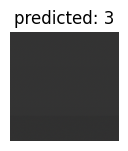

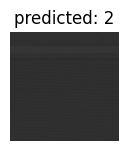

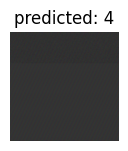

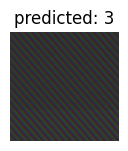

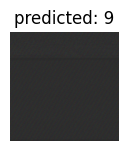

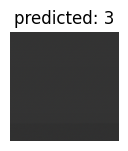

In [10]:
visualize_model(model_ft)